# E-Gamma Only
## Run Details:
- Dataset: 
- Test Goals: 
- Results Summary: 

In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
import itertools
from tqdm import tqdm
from repeating_classifier_training_utils import *

par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)
%load_ext autoreload
%matplotlib inline
%autoreload 2

## Set Run Directories Here

In [26]:
dump_dir = '/home/cmacdonald/CNN/dumps/'

paths = ['20200717_183009_no_muons','20200720_135853_no_muons_lr00002','20200721_101347_no_muons_bs32',
         '20200731_151811_egamma_transforms_train','20200803_165134_no_muons_bs32_transforms',
         '20200804_173549_no_muons_rn34','20200806_173844_egamma_fulldset_notransforms',
         '20200808_102346_egamma_fulldset_transforms']
preferred_run_idx = 3
paths = [os.path.join(dump_dir, path) for path in paths]
run_names=['LR1e-4, BS 512','LR2e-5, BS 512', 'LRe-4, BS 32', 'LRe-4, BS512, Transforms', 
           'LRe-4, BS32, Transforms', 'LRe-4, BS512, Transforms, RN34', 'Full DSet, No Transforms',
          'Full Dset, Transforms']
cut_names=[['fq_failed', 'fq_flag'] for _ in range(8)]

idx_file_paths = ['/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs_no_muons.npz' for _ in range(4)]
idx_file_paths.append('/fast_scratch/WatChMaL/data/IWCD_fulltank_300_post_veto_pe_idxs_no_muons.npz')
idx_file_paths.append('/fast_scratch/WatChMaL/data/IWCD_fulltank_300_post_veto_pe_idxs_no_muons.npz')
idx_file_paths.append('/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs_extra_nomuons.npz')
idx_file_paths.append('/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs_extra_nomuons.npz')

npz_path = os.path.join(os.getcwd(),'Index_Storage')

LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

## Plot Training History

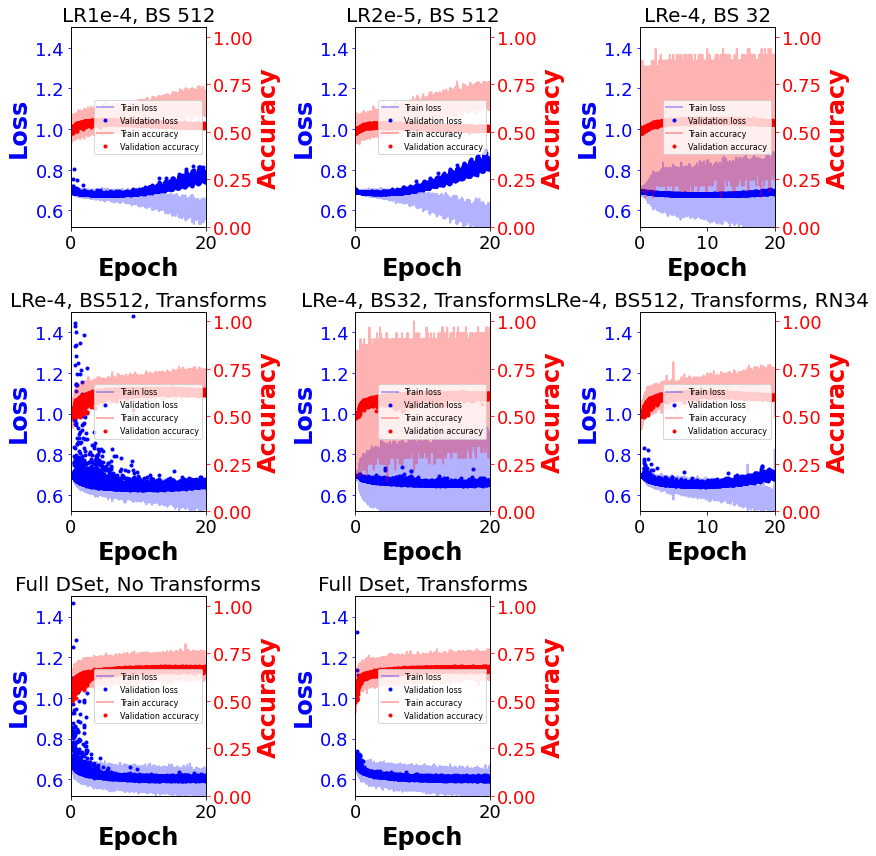

In [27]:
fig = disp_multiple_learn_hist(paths,losslim=1.5,titles=run_names,leg_font=8, title_font=20)

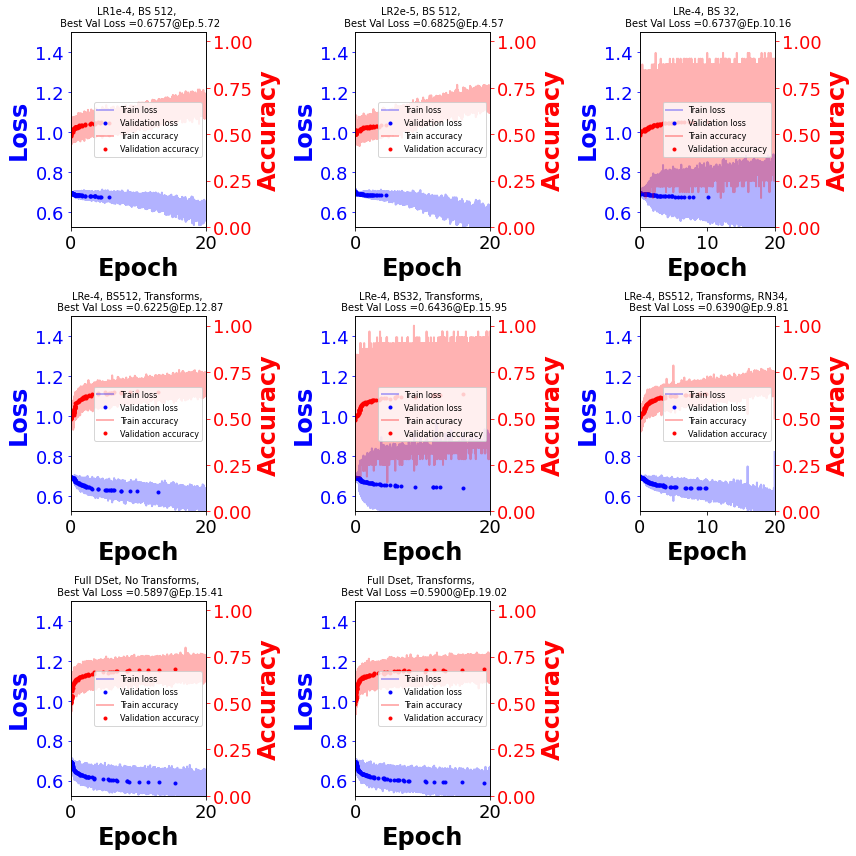

In [28]:
fig = disp_multiple_learn_hist(paths,losslim=1.5,titles=run_names,leg_font=8, title_font=10, best_only=True)

## Plot Confusion Matrices

In [29]:
paths[3] = os.path.join(dump_dir, '20200803_120925_egamma_transforms_test')

In [30]:
test_output = [load_test_output_pn(os.path.join(loc,'test_validation_iteration_dump.npz'),os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'),np.load(idx_file_paths[i])['test_idxs'], cut_names[i]) 
               for i,loc in enumerate(paths)]

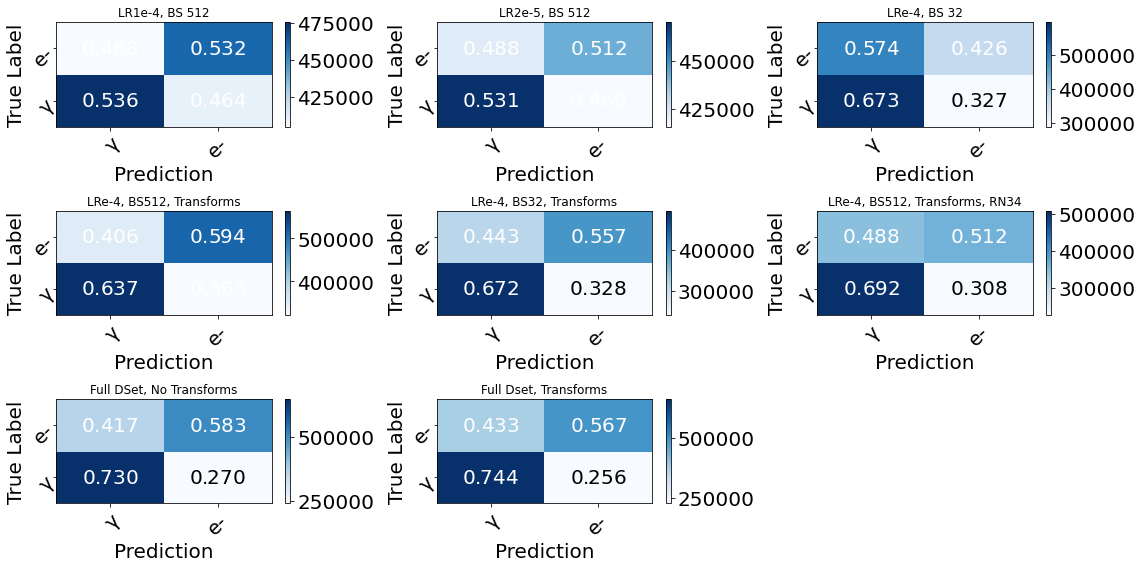

In [31]:
fig = plot_multiple_confusion_matrix([output['labels'] for output in test_output], [output['predicted_labels'] for output in test_output],
                               ['\u03B3','e-'],titles=run_names)

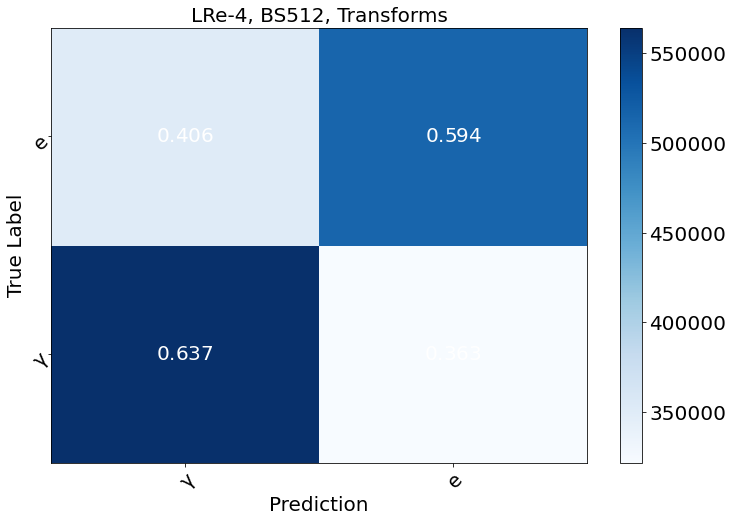

In [32]:
preferred_run=test_output[preferred_run_idx]
plot_confusion_matrix(preferred_run['labels'],preferred_run['predicted_labels'],['\u03B3','e'],title=run_names[preferred_run_idx])


In [35]:
print(f"Number of e- events: {len(np.where(test_output[-1]['labels']==1)[0])} gamma events: {len(np.where(test_output[-1]['labels']==0)[0])}")

Number of e- events: 708251 gamma events: 735030


## ROC Curves

In [33]:
fprs, tprs, thresholds = zip(*[prep_roc_data(output['softmax'],output['labels'],
                                'rejection',softmax_index_dict,"e","gamma",energies=output['energies'],) for output in test_output]
                            )

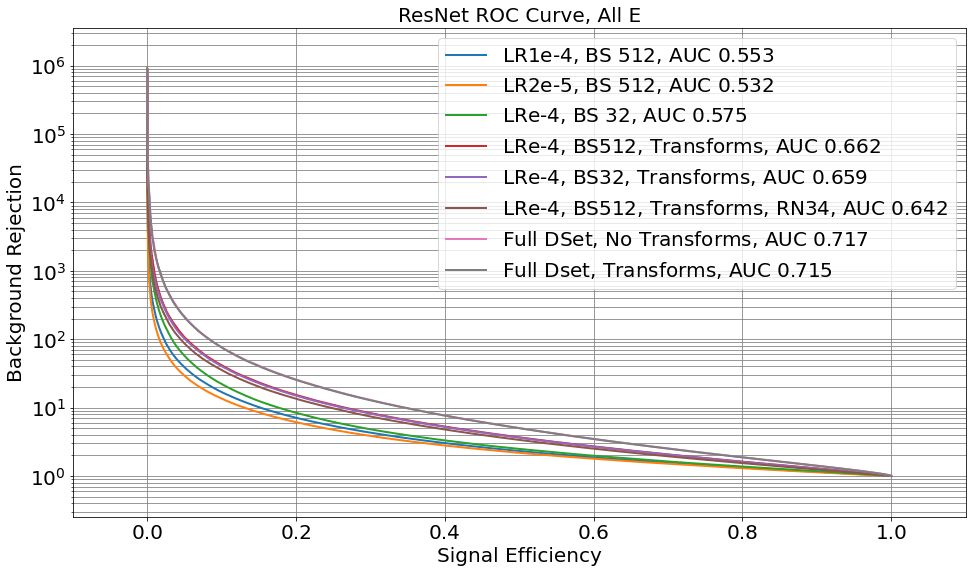

In [34]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e", "gamma"], 
                                plot_labels=run_names,
                                png_name = 'overlaid_roc',title='ResNet ROC Curve, All E',annotate=False)

In [15]:
fq_rootfiles, fq_eventids, fq_flag, fq_scores, fq_mom, fq_labels = load_fq_output(os.path.join(npz_path,'fq_mapping_idxs.npz'), os.path.join(npz_path,'fq_failed_idxs.npz'), idx_file_paths[0], os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'), cut_names[0])

In [16]:
pbar = ProgressBar(widgets=['Verification Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(fq_rootfiles))
pbar.start()
for i in range(len(fq_rootfiles)):
    assert re.sub('_fiTQun','',fq_rootfiles[i].split('/')[-1]) == preferred_run['rootfiles'][i].split('/')[-1], print(fq_rootfiles[i])
    assert fq_eventids[i] -1 == preferred_run['eventids'][i]
    pbar.update(i)
pbar.finish()
assert len(preferred_run['rootfiles']) == fq_rootfiles.shape[0]
print("Success! We now have a FiTQun output set in the same order as the h5 test set")

Success! We now have a FiTQun output set in the same order as the h5 test set


In [17]:
fprs, tprs, thresholds = zip(*[prep_roc_data(preferred_run['softmax'],preferred_run['labels'],
                                'rejection',softmax_index_dict,"e","gamma"),
                               prep_roc_data(fq_scores,fq_labels,
                                'rejection',softmax_index_dict,"e","gamma")                               
                              ]
                            )

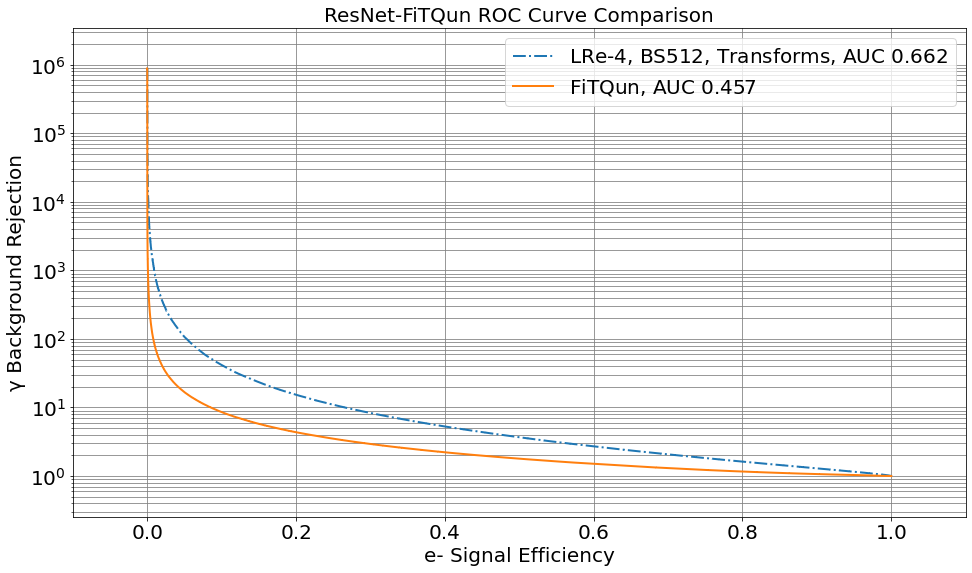

In [18]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', [["e", "gamma"],["e", 'gamma']], 
                                plot_labels = [f'{run_names[preferred_run_idx]}','FiTQun'],
                                png_name = 'overlaid_roc',title='ResNet-FiTQun ROC Curve Comparison',annotate=False,
                                linestyle=('dashdot','-','--'), xlabel='e- Signal Efficiency',ylabel='\u03B3 Background Rejection')
# plt.savefig(os.path.join(os.getcwd(),'plot_images/ROC_comparison.pdf'))

In [19]:
fractions, tprs, fprs, thresholds = zip(*[prep_roc_data(preferred_run['softmax'],preferred_run['labels'],
                                'fraction',softmax_index_dict,"e","gamma"),
                                prep_roc_data(fq_scores,fq_labels,'fraction',softmax_index_dict,"e","gamma")]
                            )

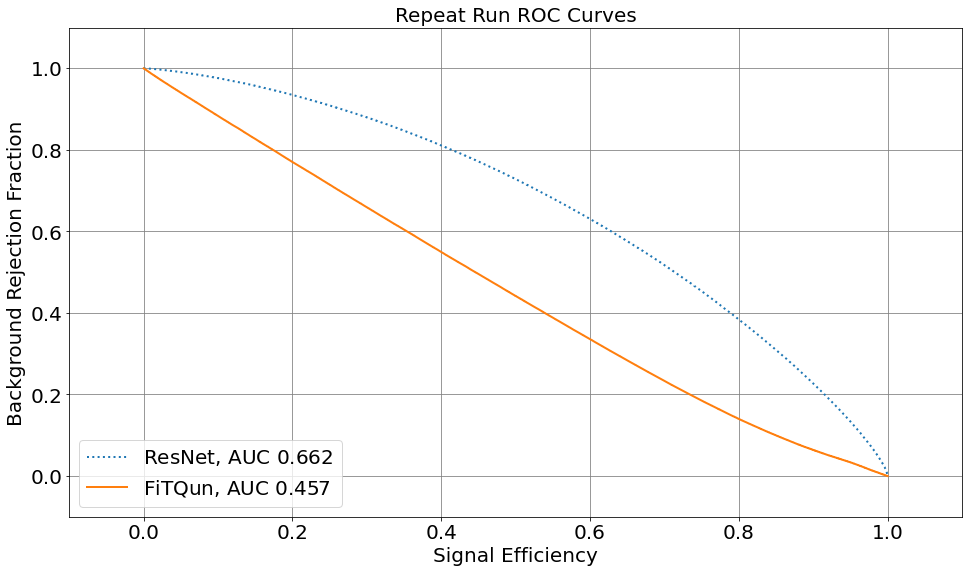

In [20]:
roc_metrics = plot_multiple_ROC((fractions, tprs, fprs, thresholds),'fraction', [["e", "gamma"],['e','gamma'],['e','mu']], 
                                plot_labels = ['ResNet','FiTQun'],
                                png_name = 'overlaid_roc',title='Repeat Run ROC Curves',annotate=False,linestyle=(':','-','--','dashdot'),
                                leg_loc='lower left')
plt.savefig(os.path.join(os.getcwd(),'plot_images/ROC_comparison_fraction.pdf'))

## Signal Purity vs Energy At Fixed Efficiency

In [26]:
GAMMA_THRESHOLD = 1.55
ELECTRON_THRESHOLD = 0.775
MUON_THRESHOLD = 160.26
shifted_energies = []

shifted_energies = np.zeros(preferred_run['labels'].shape[0])
g_idxs = np.where(preferred_run['labels']==0)[0]
e_idxs = np.where(preferred_run['labels']==1)[0]
m_idxs = np.where(preferred_run['labels']==2)[0]
shifted_energies[g_idxs] = np.squeeze(preferred_run['energies'][g_idxs] - GAMMA_THRESHOLD)
shifted_energies[e_idxs] = np.squeeze(preferred_run['energies'][e_idxs] - ELECTRON_THRESHOLD)
shifted_energies[m_idxs] = np.squeeze(preferred_run['energies'][m_idxs] - MUON_THRESHOLD)

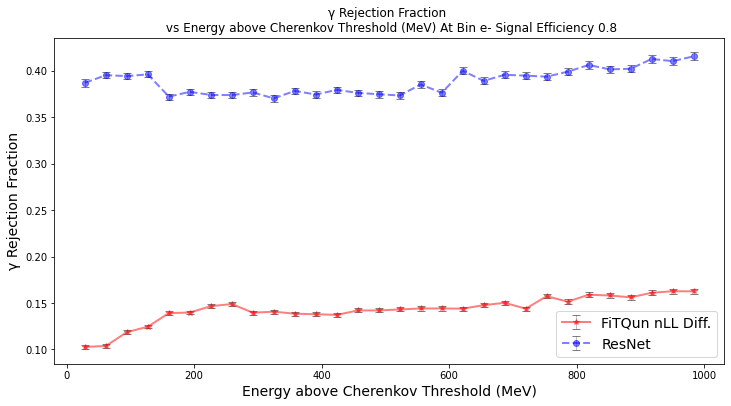

In [28]:
##Binning in Energy
scores = [fq_scores, preferred_run['softmax']]
labels = [fq_labels for _ in range(len(scores))]
binning_features = [shifted_energies,shifted_energies,np.clip(fq_mom[:,0], 0, 1000),shifted_energies]
feature_labels = ['Energy above Cherenkov Threshold (MeV)', 'Energy above Cherenkov Threshold (MeV)','FiTQun Reconstructed Electron Momentum (MeV)','Energy above Cherenkov Threshold (MeV)']
title_notes = ['',', Combined ResNet Discriminant',', Combined ResNet Discriminant','']
pos_labels = ['e']
neg_labels = ['gamma']
img_names=['rejection_vs_e.pdf','rejection_vs_e_combined_disc.pdf', 'rejection_vs_recon_e_combined_disc.pdf', 'e_gamma_rejection_vs_e.pdf']
for i in range(len(pos_labels)):
    fig, ax = plt.subplots(figsize=(12,6))
    plot_binned_performance(scores[2*i],
            labels[2*i],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='*-',color='r',ax=ax )
    plot_binned_performance(scores[2*i+1],
            labels[2*i+1],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='o--',color='b',ax=ax,title_note=title_notes[i] )    
    ax.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)

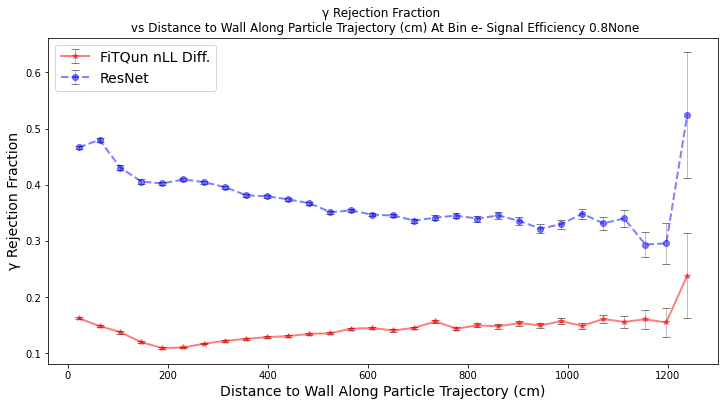

In [30]:
#Binning in d-to-wall
d_to_wall_incl_all = np.load('dist_to_wall.npz', allow_pickle=True)['test_d_to_wall']

filtered_indices = np.load("/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz", allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

idx_dic = {}
for i, idx in enumerate(test_filtered_indices):
    idx_dic[idx] = i

test_idxs = np.load(idx_file_paths[preferred_run_idx], allow_pickle=True)['test_idxs']

keep_idxs = []

for idx in test_idxs:
    try:
        keep_idxs.append(idx_dic[idx])
    except KeyError:
        pass

d_to_wall = apply_cuts(d_to_wall_incl_all[keep_idxs], test_idxs, os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'),cut_names[preferred_run_idx])
        
scores = [fq_scores, preferred_run['softmax']]
labels = [fq_labels for _ in range(len(scores))]
binning_features = [d_to_wall,d_to_wall,d_to_wall]
feature_labels = ['Distance to Wall Along Particle Trajectory (cm)','Distance to Wall Along Particle Trajectory (cm)','Distance to Wall Along Particle Trajectory (cm)']
title_notes = [None,', Combined ResNet Discriminant','']
pos_labels = ['e']
neg_labels = ['gamma']
img_names=['rejection_vs_dtowall.pdf','rejection_vs_dtowall_combined_disc.pdf', 'e_gamma_rejection_vs_dtowall.pdf']
for i in range(len(pos_labels)):
    fig, ax = plt.subplots(figsize=(12,6))
    plot_binned_performance(scores[2*i],
            labels[2*i],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='*-',color='r',ax=ax )
    plot_binned_performance(scores[2*i+1],
            labels[2*i+1],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='o--',color='b',ax=ax,title_note=title_notes[i] )    
    ax.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)
    plt.savefig(os.path.join(os.getcwd(),'plot_images',img_names[i]))

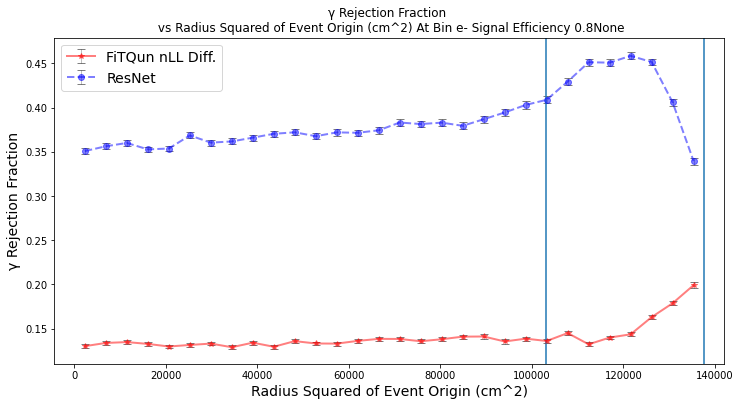

In [33]:
#Binning in origin radius squared
test_radius_incl_all = np.load('event_radii.npz')['test_radii']
filtered_indices = np.load("/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz", allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

idx_dic = {}
for i, idx in enumerate(test_filtered_indices):
    idx_dic[idx] = i

test_idxs = np.load(idx_file_paths[preferred_run_idx], allow_pickle=True)['test_idxs']

keep_idxs = []

for idx in test_idxs:
    try:
        keep_idxs.append(idx_dic[idx])
    except KeyError:
        pass

test_radius = apply_cuts(test_radius_incl_all[keep_idxs], test_idxs, os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'),cut_names[preferred_run_idx])

scores = [fq_scores, preferred_run['softmax'] ]
labels = [fq_labels for _ in range(len(scores))]
binning_features = [test_radius**2,test_radius**2,test_radius**2]
feature_labels = ['Radius Squared of Event Origin (cm^2)' for _ in range(3)]
title_notes = [None,', Combined ResNet Discriminant',None]
pos_labels = ['e']
neg_labels = ['gamma']
img_names=['rejection_vs_radius.pdf','rejection_vs_radius_combined_disc.pdf', 'e_gamma_rejection_vs_radius.pdf']
for i in range(len(pos_labels)):
    fig, ax = plt.subplots(figsize=(12,6))
    plot_binned_performance(scores[2*i],
            labels[2*i],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='*-',color='r',ax=ax )
    plot_binned_performance(scores[2*i+1],
            labels[2*i+1],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='o--',color='b',ax=ax,title_note=title_notes[i] )    
    ax.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)
    plt.axvline(x=371**2)
    plt.axvline(x=321**2)
    plt.savefig(os.path.join(os.getcwd(),'plot_images',img_names[i]))

## Plot Classifier Response

In [ ]:
fig=plot_response(preferred_run['softmax'], preferred_run['labels'], ['gamma','e','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['lower center', 'lower center', 'upper center',
                                                                                    'upper center'])
plt.savefig(os.path.join(os.getcwd(),'plot_images/resnet_response.pdf'))

In [ ]:
ns,bins = np.histogram(shifted_energies, bins=5)
left_edges = bins[0:-1]
bin_assignments = np.digitize(shifted_energies, left_edges)

In [ ]:
for BIN_NUM in range(1,6):
    bin_idxs = np.where(bin_assignments == BIN_NUM)[0]
    fig = plot_response(preferred_run['softmax'][bin_idxs,:], preferred_run['labels'][bin_idxs], ['gamma','e','mu'], 
                        softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['best', 'upper center', 'upper center',
                                                                                        'upper center'])
    a = fig.suptitle(f'Classifier Response, {np.abs(bins[BIN_NUM-1]):.2f} < E above Thresh. < {bins[BIN_NUM]:.2f}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(os.getcwd(),f'plot_images/resnet_1d_binned_response_bin{BIN_NUM}.pdf'))

In [ ]:
for i in range(fq_labels.shape[0]):
    assert fq_labels[i] == preferred_run['labels'][i]
assert fq_labels.shape[0] == preferred_run['labels'].shape[0]

## Plot Binned Response

In [ ]:
binning_features = [shifted_energies, test_radius**2, d_to_wall]
binning_labels=['Energy above Cherenkov Threshold (MeV)','Radius Squared of Event Origin (cm^2)',
                'Trajectory Distance to Wall (cm)']

In [ ]:
img_names = ['2d_resnet_binned_response_energy.pdf','2d_resnet_binned_response_radius.pdf','2d_resnet_binned_response_dtowall.pdf']
for i in range(len(binning_features)):
    fig = plot_binned_response(preferred_run['softmax'],
            preferred_run['labels'],
            binning_features[i],           
            binning_labels[i],
            0.8, 30, 30,softmax_index_dict,
            log_scales=[2,6,8,9,11,3,7,10]
            )
    plt.savefig(os.path.join(os.getcwd(),'plot_images',img_names[i])) 